In [109]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score,f1_score,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score


In [111]:
data = pd.read_csv('./train.csv')
def for_prepare(data):
    columns_for_drop = ['age_desc','ID','ethnicity','gender','contry_of_res','used_app_before','relation','Class/ASD']
    return data.drop(columns_for_drop, axis = 1)

df_for_prepare = for_prepare(data)
print(df_for_prepare.shape)

def get_for_Scale_cols(data):
    return data.select_dtypes(include=[np.number]).values

def get_OneHotEnc_col(data):
    return data.select_dtypes(exclude=[np.number]).values

my_prepare = make_union(*[
    make_pipeline(FunctionTransformer(get_OneHotEnc_col, validate=False),  OneHotEncoder(sparse_output=False)),
    make_pipeline(FunctionTransformer(get_for_Scale_cols, validate=False), StandardScaler())
    ])

x = my_prepare.fit_transform(df_for_prepare)
print(print(x.shape))
y = data['Class/ASD'].values

(800, 14)
(800, 16)
None


In [115]:
# Поэтапно поделим выборку на 3 части для обучения, настройки гиперпараметров и тестирования
X_trainval, X_test, y_trainval, y_test = train_test_split(x,y,test_size=0.2, stratify=y, random_state=12)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval,stratify=y_trainval, random_state=12)
print("Размер выборки training: {}, размер выборки для настройки параметров: {}, размер выборки для тестирования:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

Размер выборки training: 480, размер выборки для настройки параметров: 160, размер выборки для тестирования: 160



Я настривала гиперпараметры и пробовала применить следующие модели:


*   МОДЕЛЬ SVC
*   МОДЕЛЬ LogisticRegression
*   МОДЕЛЬ RandomForestClassifier
*   МОДЕЛЬ XGBoost classifier
*   МОДЕЛЬ KNeighborsClassifier

Здесь я максимизировала метрику ROC AUC для положительного класса (1), так как в данной задаче критичным является качество модели по определению положительного класса при ранней диагностике аутизма.AUC представляет собой площадь под кривой ROC в диапазоне от 0,0 до 1,0, причем более высокое значение указывает на лучшую производительность классификатора .




# **МОДЕЛЬ SVC**

In [116]:
%%time
best_score = 0
for gamma in [0.001, 0.01, 0.1, 1]:
    for C in [0.001, 0.01, 0.1, 1]:
        model = SVC(gamma=gamma, C=C,probability=True)
        model.fit(X_train, y_train)
        y_pred_prob = model.predict_proba(X_valid)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_valid, y_pred_prob, pos_label=1)
        score = roc_auc_score(y_valid, y_pred_prob)
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

model = SVC(**best_parameters,probability=True)
model.fit(X_trainval, y_trainval)
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
test_roc_auc_score = roc_auc_score(y_test, y_pred_prob)
print("Лучший показатель ROC AUC на выборке валидации: {:.2f}".format(best_score))
print("Лучшие параметры: ", best_parameters)
print("Показатель ROC AUC на выборке валидации: {:.2f}".format(test_roc_auc_score))

Лучший показатель ROC AUC на выборке валидации: 0.91
Лучшие параметры:  {'C': 0.01, 'gamma': 0.01}
Показатель ROC AUC на выборке валидации: 0.95
CPU times: user 681 ms, sys: 803 µs, total: 681 ms
Wall time: 695 ms


# **МОДЕЛЬ LogisticRegression**

In [117]:
%%time
best_score = 0
for penalty in ['l1', 'l2']:
    for C in [0.01, 0.1, 1, 10]:
        model = LogisticRegression(solver='saga',penalty = penalty, C=C, max_iter = 1000)
        model.fit(X_train, y_train)
        y_pred_prob = model.predict_proba(X_valid)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_valid, y_pred_prob, pos_label=1)
        score = roc_auc_score(y_valid, y_pred_prob)
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'solver': 'saga','penalty': penalty}

model =LogisticRegression(**best_parameters)
model.fit(X_trainval, y_trainval)
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
test_roc_auc_score = roc_auc_score(y_test, y_pred_prob)
print("Лучший показатель ROC AUC на выборке валидации: {:.2f}".format(best_score))
print("Лучшие параметры: ", best_parameters)
print("Показатель ROC AUC на выборке валидации: {:.2f}".format(test_roc_auc_score))

Лучший показатель ROC AUC на выборке валидации: 0.91
Лучшие параметры:  {'C': 0.1, 'solver': 'saga', 'penalty': 'l2'}
Показатель ROC AUC на выборке валидации: 0.95
CPU times: user 255 ms, sys: 1.56 ms, total: 257 ms
Wall time: 259 ms


# **МОДЕЛЬ RandomForestClassifier**

---



In [118]:
%%time

best_score = 0
for n_estimators in [5, 20, 100, 150]:
    for max_depth in [None,3, 5, 10]:
        for min_samples_split in [2, 5, 10]:
            model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,min_samples_split = min_samples_split, class_weight='balanced')
            model.fit(X_train, y_train)
            y_pred_prob = model.predict_proba(X_valid)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_valid, y_pred_prob, pos_label=1)
            score = roc_auc_score(y_valid, y_pred_prob)
            if score > best_score:
                best_score = score
                best_parameters = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split}

model =RandomForestClassifier(**best_parameters)
model.fit(X_trainval, y_trainval)
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
test_roc_auc_score = roc_auc_score(y_test, y_pred_prob)
print("Лучший показатель ROC AUC на выборке валидации: {:.2f}".format(best_score))
print("Лучшие параметры: ", best_parameters)
print("Показатель ROC AUC на выборке валидации: {:.2f}".format(test_roc_auc_score))

Лучший показатель ROC AUC на выборке валидации: 0.92
Лучшие параметры:  {'n_estimators': 5, 'max_depth': 5, 'min_samples_split': 2}
Показатель ROC AUC на выборке валидации: 0.93
CPU times: user 7 s, sys: 29.9 ms, total: 7.03 s
Wall time: 7.54 s


# **МОДЕЛЬ XGBoost classifier**

In [119]:
%%time

best_score = 0
for n_estimators in [5, 20, 100]:
    for max_depth in [2, 3, 5, 7]:
        for learning_rate in [0.1, 0.01, 0.001, 0.2]:
            for gamma in [0.2, 0.4, 0.6, 0.9]:
                model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth,learning_rate = learning_rate,
                gamma = gamma)
                model.fit(X_train, y_train)
                y_pred_prob = model.predict_proba(X_valid)[:, 1]
                fpr, tpr, thresholds = roc_curve(y_valid, y_pred_prob, pos_label=1)
                score = roc_auc_score(y_valid, y_pred_prob)
                if score > best_score:
                    best_score = score
                    best_parameters = {'n_estimators': n_estimators, 'max_depth': max_depth,
                                       'learning_rate': learning_rate,
                                       'gamma': gamma}
model =XGBClassifier(**best_parameters)
model.fit(X_trainval, y_trainval)
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
test_roc_auc_score = roc_auc_score(y_test, y_pred_prob)
print("Лучший показатель ROC AUC на выборке валидации: {:.2f}".format(best_score))
print("Лучшие параметры: ", best_parameters)
print("Показатель ROC AUC на выборке валидации: {:.2f}".format(test_roc_auc_score))

Лучший показатель ROC AUC на выборке валидации: 0.92
Лучшие параметры:  {'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.2, 'gamma': 0.9}
Показатель ROC AUC на выборке валидации: 0.93
CPU times: user 12.3 s, sys: 242 ms, total: 12.5 s
Wall time: 6.81 s


# **МОДЕЛЬ KNeighborsClassifier**

In [120]:
%%time
best_score = 0

for n_neighbors in [3, 5, 8, 12, 15]:
    for weights in ['uniform', 'distance']:
        model = KNeighborsClassifier(n_neighbors = n_neighbors, weights=weights)
        model.fit(X_train, y_train)
        y_pred_prob = model.predict_proba(X_valid)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_valid, y_pred_prob, pos_label=1)
        score = roc_auc_score(y_valid, y_pred_prob)
        if score > best_score:
            best_score = score
            best_parameters = {'weights': weights, 'n_neighbors': n_neighbors}

model =KNeighborsClassifier(**best_parameters)
model.fit(X_trainval, y_trainval)
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
test_roc_auc_score = roc_auc_score(y_test, y_pred_prob)
print("Лучший показатель ROC AUC на выборке валидации: {:.2f}".format(best_score))
print("Лучшие параметры: ", best_parameters)
print("Показатель ROC AUC на выборке валидации: {:.2f}".format(test_roc_auc_score))

Лучший показатель ROC AUC на выборке валидации: 0.89
Лучшие параметры:  {'weights': 'distance', 'n_neighbors': 15}
Показатель ROC AUC на выборке валидации: 0.92
CPU times: user 993 ms, sys: 4.6 ms, total: 997 ms
Wall time: 1.03 s


# **ВЫБОР МОДЕЛИ:**
# Лучше всего зарекомендовала себя модель LogisticRegression(solver='saga',penalty = 'l2', C=0.01, max_iter = 1000). С подобранными гиперпараметрами для этой модели показатель ROC AUC для положительного класса на выборке валидации: 0.95.
Wall time: 343 ms

In [121]:
model = LogisticRegression(solver='saga',penalty = 'l2', C=0.01, max_iter = 1000)
model.fit(x,y)

LogisticRegression(C=0.01, max_iter=1000, solver='saga')

# **Сохраняем модель**

In [122]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

К сожалению, для того, чтобы выяснить, названия самых значимых факторов в данной модели, придется проделать эти же приобразования с данными второй раз, использую не OneHot в make_pipeline, а pd.get_dummies, а потом снова обучить модель и посмотреть на постороенном графике на значимость факторов.

(800, 16)


[Text(0, 0, '-0.081'),
 Text(0, 0, '-0.019'),
 Text(0, 0, '0.019'),
 Text(0, 0, '0.05'),
 Text(0, 0, '0.081'),
 Text(0, 0, '0.087'),
 Text(0, 0, '0.108'),
 Text(0, 0, '0.143'),
 Text(0, 0, '0.161'),
 Text(0, 0, '0.174'),
 Text(0, 0, '0.176'),
 Text(0, 0, '0.203'),
 Text(0, 0, '0.21'),
 Text(0, 0, '0.214'),
 Text(0, 0, '0.214'),
 Text(0, 0, '0.297')]

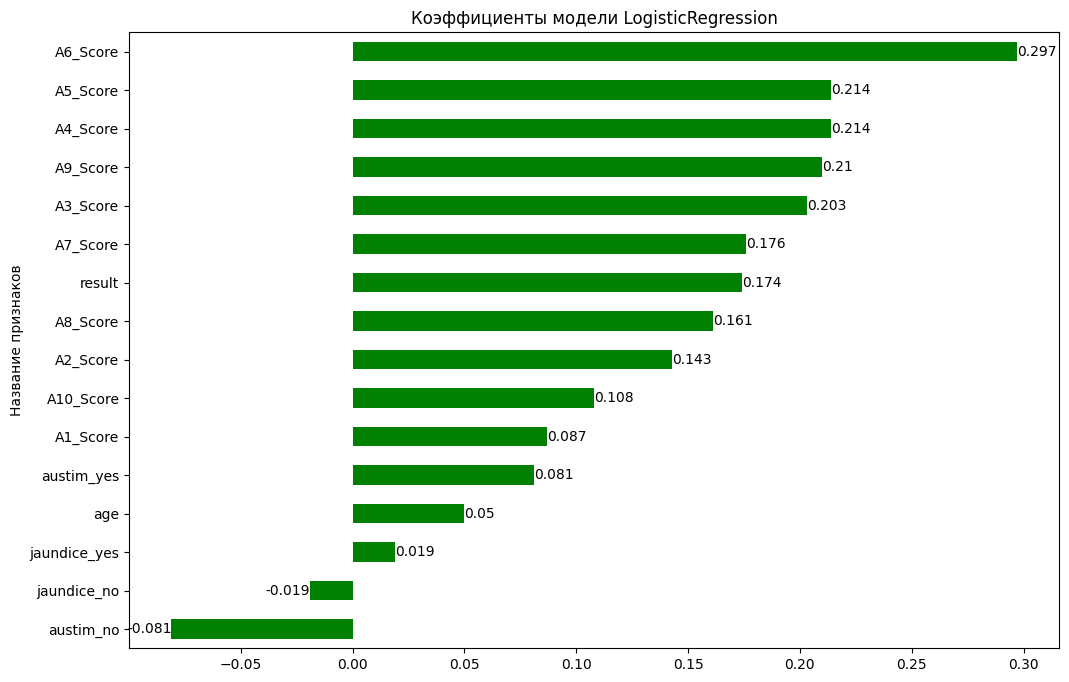

In [123]:
data = pd.read_csv('./train.csv')
df = for_prepare(data)
col_names = df.select_dtypes(include=[np.number]).columns
features = df.select_dtypes(include=[np.number])
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)
obj_df = df.select_dtypes(exclude=[np.number])
obj_df = pd.get_dummies(obj_df, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)
newdf =pd.concat([scaled_features,obj_df],axis=1, join="inner")
print(newdf.shape)
x = newdf.values
y = data['Class/ASD'].values

# Поэтапно поделим выборку на 3 части для обучения, настройки гиперпараметров и тестирования
X_trainval, X_test, y_trainval, y_test = train_test_split(x,y,test_size=0.2, stratify=y, random_state=12)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval,stratify=y_trainval, random_state=12)

model =LogisticRegression(solver='saga',penalty = 'l2', C=0.01, max_iter = 4000)
model.fit(X_trainval, y_trainval)
coef = model.coef_.ravel()
feature_imp = list(round(x,3) for x in coef)
factors_names = newdf.columns
df_plot = pd.DataFrame({'Коэффициенты значимости': feature_imp}, factors_names).sort_values(['Коэффициенты значимости'])
ax = df_plot.plot(kind='barh', figsize=(12, 8), title='Коэффициенты модели LogisticRegression',
             ylabel='Название признаков', legend=False, color='green')
ax.bar_label(ax.containers[0], label_type='edge')

# **ВЫВОДЫ: **

1. Лучше всего зарекомендовала себя модель LogisticRegression(solver='saga',penalty = 'l2', C=0.01, max_iter = 1000). С подобранными гиперпараметрами для этой модели показатель ROC AUC для положительного класса на выборке валидации: 0.95.

2.   Первых 5 наиболее значимых факторов по выбранной модели (в порядке убывания):

*   A6_Score (0.297)
*   A5_Score (0.214)
*   A4_Score (0.214)
*   A9_Score (0.21)
*   A3_Score (0.203)
















# **Расставляем классы в тестовом наборе, используя нашу модель. Сохраняем файл с ответами.**

In [124]:
test_with_classes = pd.read_csv('./test.csv')
def for_prepare(data):
    columns_for_drop = ['age_desc','ID','ethnicity','gender','contry_of_res','used_app_before','relation']
    return data.drop(columns_for_drop, axis = 1)

df_for_prepare = for_prepare(test_with_classes)


def get_for_Scale_cols(data):
    return data.select_dtypes(include=[np.number]).values

def get_OneHotEnc_col(data):
    return data.select_dtypes(exclude=[np.number]).values

my_prepare = make_union(*[
    make_pipeline(FunctionTransformer(get_OneHotEnc_col, validate=False),  OneHotEncoder(sparse_output=False)),
    make_pipeline(FunctionTransformer(get_for_Scale_cols, validate=False), StandardScaler())
    ])

x_new = my_prepare.fit_transform(df_for_prepare)
test_with_classes['Class/ASD'] = model.predict(x_new)
test_with_classes.to_csv("test_with_classes.csv", index=False)